# Exersice 5: VAE, new code added at the end of the notebook
# Faisal Omari - 325616894
# Fadi Khateeb - 308052992

In [1]:
## Standard libraries
import os
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipykernel_56637/3242715609.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
/home/faisal/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/faisal/anaconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

We again provide a pretrained model, which is downloaded below:

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleList | 2.0 M 
--------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.936     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1823: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            -6142.4013671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
finish


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


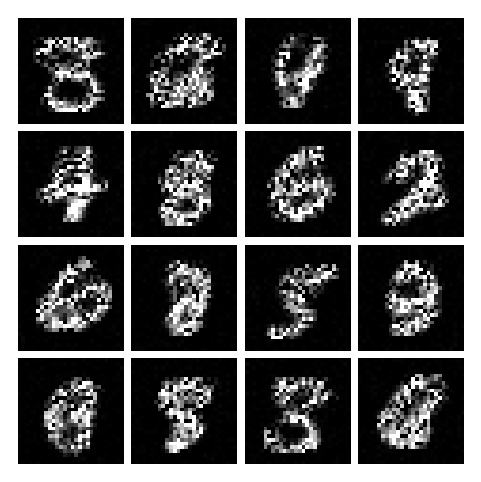

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Define checkpoint path
CHECKPOINT_PATH = "./checkpoints"

# Define the Coupling Layer
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, alternate):
        super(CouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.half_dim = input_dim // 2
        self.alternate = alternate

        self.network = nn.Sequential(
            nn.Linear(self.half_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, self.half_dim)
        )
        self.scale = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        if self.alternate:
            x2, x1 = x[:, :self.half_dim], x[:, self.half_dim:]
        else:
            x1, x2 = x[:, :self.half_dim], x[:, self.half_dim:]

        h = self.network(x1)
        h = torch.clamp(h, min=-5.0, max=5.0)  # Clipping the values of h
        z1 = x1
        z2 = x2 * torch.exp(h) + self.scale[:self.half_dim]
        z = torch.cat([z1, z2], dim=1) if not self.alternate else torch.cat([z2, z1], dim=1)
        log_det_jacobian = torch.sum(h, dim=1)
        return z, log_det_jacobian

    def inverse(self, z):
        if self.alternate:
            z2, z1 = z[:, :self.half_dim], z[:, self.half_dim:]
        else:
            z1, z2 = z[:, :self.half_dim], z[:, self.half_dim:]

        h = self.network(z1)
        h = torch.clamp(h, min=-5.0, max=5.0)  # Clipping the values of h
        x1 = z1
        x2 = (z2 - self.scale[:self.half_dim]) / torch.exp(h)
        x = torch.cat([x1, x2], dim=1) if not self.alternate else torch.cat([x2, x1], dim=1)
        return x

# Define the Normalizing Flow Model
class NormalizingFlowModel(pl.LightningModule):
    def __init__(self, input_dim, num_flows):
        super(NormalizingFlowModel, self).__init__()
        self.save_hyperparameters()
        self.num_flows = num_flows
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []

        self.layers = nn.ModuleList([CouplingLayer(input_dim, i % 2 == 1) for i in range(num_flows)])
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        
    def forward(self, x):
        log_det_jacobian = torch.zeros(x.size(0)).to(x.device)
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def inverse(self, z):
        intermediates = [z]
        for layer in reversed(self.layers):
            z = layer.inverse(z)
            intermediates.append(z)
        return z, intermediates

    def calc_likelihood(self, x):
        z, log_det_jacobian = self.forward(x)
        z = torch.clamp(z, min=-10.0, max=10.0)  # Clipping the values of z
        log_pz = self.prior.log_prob(z).sum(dim=1)
        log_likelihood = log_pz + log_det_jacobian
        return -torch.mean(log_likelihood)

    def sample(self, num_samples):
        z = torch.randn(num_samples, self.hparams.input_dim).to(self.device)
        x, intermediates = self.inverse(z)
        return x, intermediates

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1).float()
        x = x / 255.0  # Normalizing the input data
        loss = self.calc_likelihood(x)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1).float()
        x = x / 255.0  # Normalizing the input data
        loss = self.calc_likelihood(x)
        self.log('val_loss', loss)
        self.val_losses.append(loss.item())


    def test_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1).float()
        x = x / 255.0  # Normalizing the input data
        loss = self.calc_likelihood(x)
        self.log('test_loss', loss)
        self.test_losses.append(loss.item())

# CHECKPOINT_PATH = "./checkpoints"
        
# Data preparation
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(mnist_test, batch_size=64)
test_loader = DataLoader(mnist_test, batch_size=64)

def train_model(input_dim, num_flows):
    model = NormalizingFlowModel(input_dim, num_flows)
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "NormalizingFlowModel"), 
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=100,
                         gradient_clip_val=1.0, 
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor("epoch")])
    trainer.fit(model, train_loader, val_loader)
    torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, "NormalizingFlowModel", "200model.pth"))

    return model

model = train_model(input_dim=28*28, num_flows=4)

# Evaluate the model
trainer = pl.Trainer()
trainer.test(model, test_loader)


#1- Generate and display samples
samples, _ = model.sample(16)
samples = samples.view(-1, 1, 28, 28).cpu().detach() * 255.0
# Assuming show_imgs is a function to display images
show_imgs(samples)


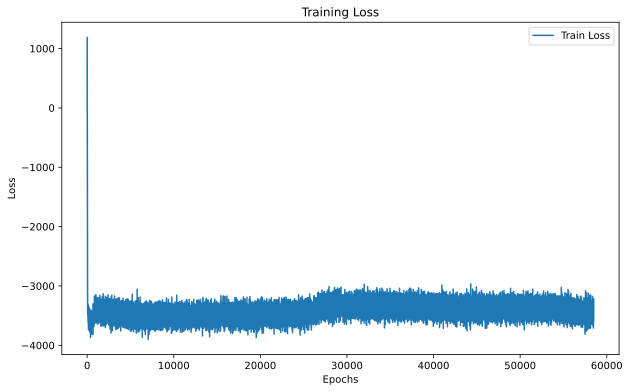

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.train_losses, label='Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

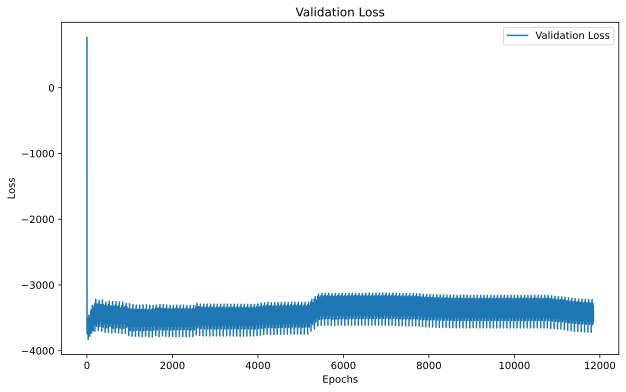

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.val_losses, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

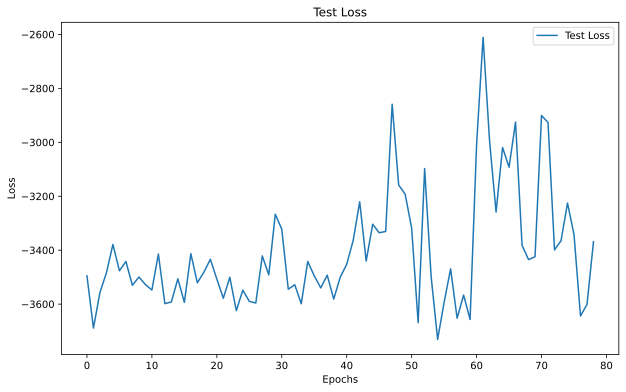

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model.test_losses, label='Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()


In [ ]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN"), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=150, 
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")])
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "PixelCNN.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = PixelCNN.load_from_checkpoint(pretrained_filename)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = PixelCNN(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)
    
    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

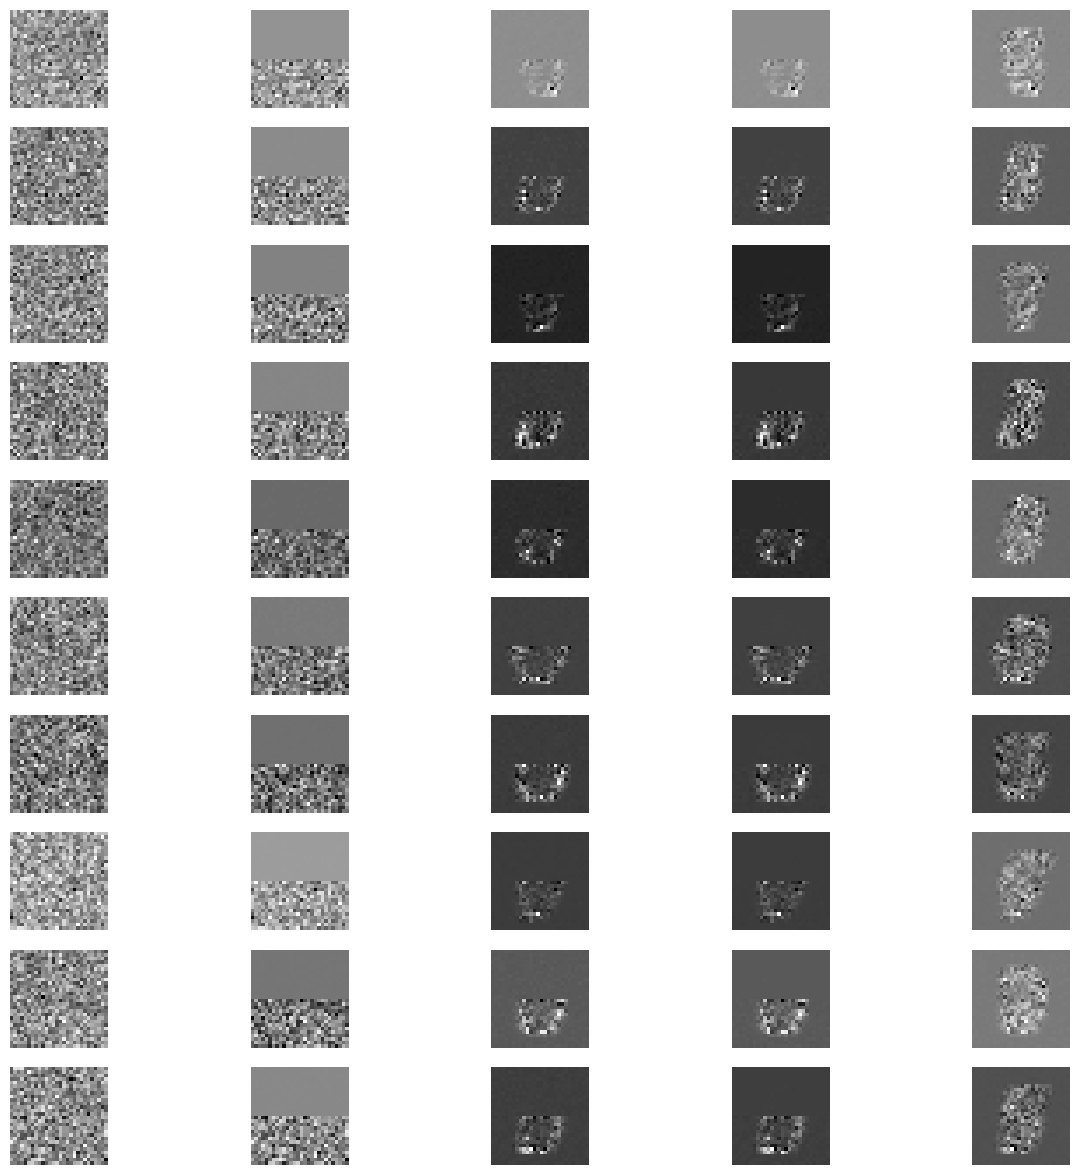

In [ ]:
#2- transformation of samples from the latent distribution z to the data distribution

num_samples = 10
x_samples, intermediates = model.sample(num_samples)

# Prepare grid for displaying images
fig, axes = plt.subplots(num_samples, len(intermediates), figsize=(15, 15))
for i in range(num_samples):
    for j, intermediate in enumerate(intermediates):
        intermediate_sample = intermediate[i].view(28, 28).cpu().detach().numpy()
        axes[i, j].imshow(intermediate_sample, cmap='gray')
        axes[i, j].axis('off')

plt.show()


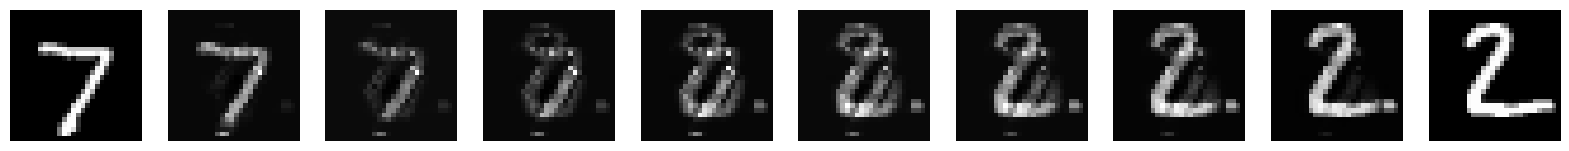

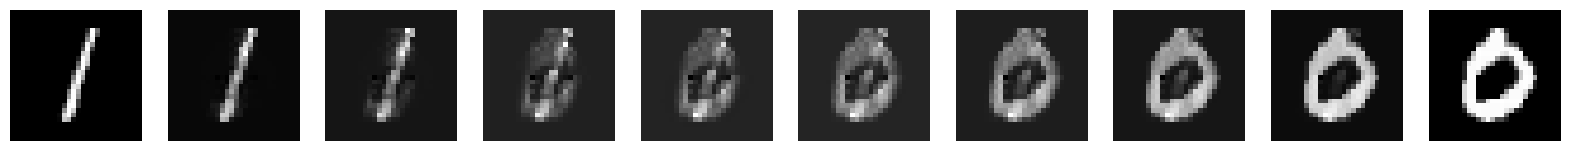

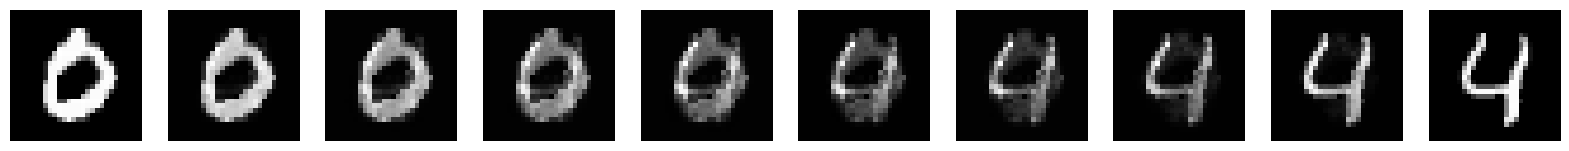

In [ ]:
def plot_latent_traversals(image1, image2):

    # Prepare the images
    image1 = image1.view(1, -1).float() / 255.0
    image2 = image2.view(1, -1).float() / 255.0

    # Encode the images to get their latent representations
    z1, _, _ = model.forward(image1)
    z2, _, _ = model.forward(image2)

    # Generate 10 points along the linear path between z1 and z2
    interpolated_z = [z1 + (z2 - z1) * t for t in torch.linspace(0, 1, steps=10)]

    # Decode the interpolated latent representations
    reconstructed_images = [model.inverse(z)[0].view(28, 28).cpu().detach().numpy() for z in interpolated_z]

    # Visualize the transformation from one digit to another
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(reconstructed_images[i], cmap='gray')
        ax.axis('off')

    plt.show()
    
    
plot_latent_traversals(mnist_test[0][0], mnist_test[1][0])
plot_latent_traversals(mnist_test[2][0], mnist_test[3][0])
plot_latent_traversals(mnist_test[3][0], mnist_test[4][0])


